# 14: Adventures in Covariance

In the previous chapter on multilevel modeling, our adaptive priors allowed us to use data about one subgroup of the data to learn about other groups. However, that knowledge transfer was limited to parameters of the same type. Like in the chimpanzee example, all of our $\alpha_j$'s had one prior parametrized by $\bar{\alpha}$ and $\sigma_\alpha$, and all the $\gamma_j$'s were parametrized by a $\sigma_\gamma$. Learning something about $\alpha_1$ helped us learn a bit about $\alpha_2$, but nothing about $\gamma_2$. In real life, sometimes there are correlations between different types of variables that allow us to learn something about multiple types at the same time and squeeze more information from our data.

In [1]:
%load_ext autoreload
%autoreload 2
%cd "/home/ecotner/statistical-rethinking/"

/home/ecotner/statistical-rethinking


In [171]:
import sys, warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Path, PathPatch
import seaborn as sns
import scipy.stats as stats
from scipy import interpolate
import torch
import torch.tensor as tt
import pyro
from pyro import poutine
from pyro.distributions import (
    MultivariateNormal, Normal, LKJCorrCholesky, Exponential, Bernoulli, Poisson, HalfNormal
)
from pyro.infer import Predictive
from pyro.ops.stats import waic, hpdi
import arviz as az
import xarray as xr
import networkx as nx

sys.path.insert(0, "/home/ecotner/statistical-rethinking/code/")
from utils import traceplot, train_nuts, unnest_samples

torch.multiprocessing.set_sharing_strategy("file_system")
pyro.enable_validation()

### Code 14.1 - 14.17
For example, if we consider our cafe-visiting robot example from before, perhaps as it goes from cafe to cafe, it also orders multiple drinks; one in the morning, and one in the afternoon. As it turns out, popular cafes are very busy in the morning (and have long wait times), and have much lower waits during the afternoon. Unpopular cafes have low wait times in both the morning and afternoon. So if the robot visits a cafe in the morning and observes that it takes a while to get it's order, it can already make a good guess that the wait in the afternoon will be significantly less. In this example, the wait times and time of day are correlated.

We can do a simulation to demonstrate this relationship and how it can be harnessed in our multilevel models. First, we will sample from a multivariate normal distribution representing the slopes and intercepts of our model for how the _average_ waiting time of the population of cafes changes according to time of day.

In [3]:
a = 3.5 # average morning wait time
b = -1 # avg. difference between afternoon/morning waits
sigma_a = 1.
sigma_b = 0.5
rho = -0.7 # correlation between intercepts and slopes

Mu = tt([a, b])
cov_ab = sigma_a*sigma_b*rho
Sigma = tt([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])

N_cafes = 20
vary_effects = MultivariateNormal(Mu, Sigma).sample([N_cafes])

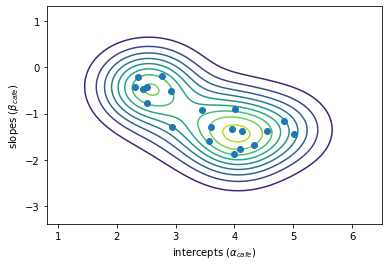

In [4]:
plt.scatter(*vary_effects.T)
sns.kdeplot(*vary_effects.T.numpy(), cmap="viridis", zorder=-1, bw=0.5)
plt.xlabel(r"intercepts ($\alpha_{cafe}$)")
plt.ylabel(r"slopes ($\beta_{cafe}$)")
plt.show()

Then, we can take our slopes/intercepts sampled from the population, compute the average wait times, and then sample from a normal distribution centered on _that_ average.

In [5]:
N_visits = 10
afternoon = tt((N_cafes*N_visits//2)*[0, 1])
cafe_id = tt(sum([N_visits*[i] for i in range(N_cafes)], []))
a_cafe, b_cafe = vary_effects.T
mu = a_cafe[cafe_id] + b_cafe[cafe_id]*afternoon
sigma = tt(0.5)
wait = Normal(mu, sigma).sample()
df = pd.DataFrame({"cafe": cafe_id.numpy(), "afternoon": afternoon.numpy(), "wait": wait.numpy()})
df.sample(5)

,cafe,afternoon,wait
169,16,1,2.016071
81,8,1,2.209045
43,4,1,1.593509
59,5,1,1.498043
147,14,1,2.428012


Now, we're going to build a Bayesian model of our cafe waiting time process. It has the following structure:

$$\begin{align*}
W_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha_\text{cafe[i]} + \beta_\text{cafe[i]} A_i \\
\begin{pmatrix} \alpha_\text{cafe}\\ \beta_\text{cafe} \end{pmatrix} &\sim \text{MVNormal}\left(\begin{pmatrix} \alpha\\ \beta \end{pmatrix}, \boldsymbol{S}\right) \\
\boldsymbol{S} &= \begin{pmatrix} \sigma_\alpha & 0 \\ 0 & \sigma_\beta \end{pmatrix} \boldsymbol{R} \begin{pmatrix} \sigma_\alpha & 0 \\ 0 & \sigma_\beta \end{pmatrix} \\
\alpha &\sim \text{Normal}(5, 2) \\
\beta &\sim \text{Normal}(-1, 0.5) \\
\sigma &\sim \text{Exponential}(1) \\
\sigma_\alpha &\sim \text{Exponential}(1) \\
\sigma_\beta &\sim \text{Exponential}(1) \\
\boldsymbol{R} &\sim \text{LKJcorr}(2)
\end{align*}$$

In [6]:
data = dict(
    n_cafes=df["cafe"].nunique(),
    cafe=tt(df["cafe"].values).long(),
    afternoon=tt(df["afternoon"].values).double(),
    wait=tt(df["wait"].values).double()
)

def model_m14_1(data, training=False):
    n_cafes = data["n_cafes"]
    R = pyro.sample("R", LKJCorrCholesky(2, tt(2.)))
    σα = pyro.sample("σα", Exponential(1.).expand([1]))
    σβ = pyro.sample("σβ", Exponential(1.).expand([1]))
    σ = pyro.sample("σ", Exponential(1.))
    α = pyro.sample("α", Normal(4., 2.).expand([1]))
    β = pyro.sample("β", Normal(-1., 0.5).expand([1]))
    S = torch.diag(torch.cat([σα, σβ]))
    S = S @ R @ S
    M = torch.cat([α, β])
    α_cafe, β_cafe = pyro.sample("cafe", MultivariateNormal(M, scale_tril=S).expand([n_cafes])).T
    C, A = data["cafe"], data["afternoon"]
    μ = α_cafe[C] + β_cafe[C] * A
    if training:
        pyro.sample("W", Normal(μ, σ), obs=data["wait"])
    else:
        return pyro.sample("W", Normal(μ, σ))

In [13]:
# if you use jit_compile=True, it doesn't work; why?
m14_1 = train_nuts(
    model_m14_1, data, 500, 1000,
    step_size=1e-3, adapt_step_size=True, adapt_mass_matrix=True, jit_compile=False
)

Warmup:   0%|          | 5/1500 [00:00, 42.42it/s, step size=1.01e-03, acc. prob=0.600]

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': False, 'step_size': 0.001}


Sample: 100%|██████████| 1500/1500 [02:21, 10.59it/s, step size=2.88e-01, acc. prob=0.863]


In [16]:
m14_1.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    R[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
    R[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
    R[1,0]     -0.52      0.17     -0.54     -0.82     -0.29       nan      1.00
    R[1,1]      0.83      0.10      0.84      0.69      1.00       nan      1.00
     σα[0]      0.89      0.08      0.89      0.76      1.03    795.34      1.00
     σβ[0]      0.60      0.10      0.60      0.44      0.76    209.77      1.00
         σ      0.54      0.03      0.54      0.49      0.58   1013.54      1.00
      α[0]      3.50      0.20      3.50      3.15      3.79    876.79      1.00
      β[0]     -0.99      0.12     -0.99     -1.21     -0.81    700.23      1.00
 cafe[0,0]      2.91      0.21      2.91      2.58      3.25   1342.70      1.00
 cafe[0,1]     -0.91      0.25     -0.91     -1.36     -0.54   1175.98      1.00
 cafe[1,0]      3.41      0

If we examine the inferred parameters, we can see that they are relatively close to the actual parameters!

| parameter | actual | post. mean | post. std. |
| :---: | :---: | :---: | :---: |
| $\alpha$ | 3.5 | 3.50 | 0.20 |
| $\beta$ | -1.0 | -0.99 | 0.12 |
| $\sigma_\alpha$ | 1 | 0.89 | 0.08 |
| $\sigma_\beta$ | 0.5 | 0.60 | 0.10 |
| $\rho$ | -0.7 | -0.52 | 0.17 |

Let's take a look at the posterior for the correlation coefficient $\rho$ (which we have to extract carefully from the correlation matrix $R$)

posterior rho: -0.5206630825996399 +/- 0.17166778445243835


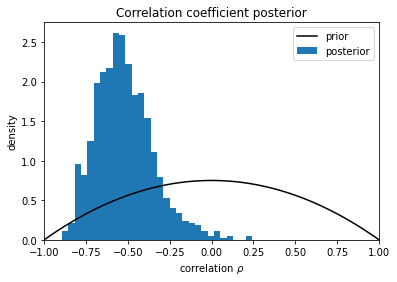

In [50]:
# plot posterior samples
R = m14_1.get_samples()["R"]
R = torch.einsum("ijk,ilk->ijl", R, R)
rho = R[:,0,1]
print("posterior rho:", rho.mean().item(), "+/-", rho.std().item())
plt.hist(rho, bins=30, density=True, label="posterior")
# plot prior density
rho = torch.linspace(-0.999, .999, 50)
R = torch.ones(len(rho), 2, 2).double()
R[:,0,1] = rho
R[:,1,0] = rho
L = torch.cholesky(R)
p = LKJCorrCholesky(2, tt(2.)).log_prob(L).exp()
plt.plot(rho, p, color="black", label="prior")
# labels
plt.xlabel(r"correlation $\rho$")
plt.ylabel("density")
plt.title("Correlation coefficient posterior")
plt.xlim(left=-1, right=1)
plt.legend()
plt.show()

Let's visualize the shrinkage that we get from using our multilevel model as opposed to one that doesn't pool observations. We'll plot the distribution of intercepts/slopes, and morning/afternoon waits, comparing the observed values and the mean posterior samples.

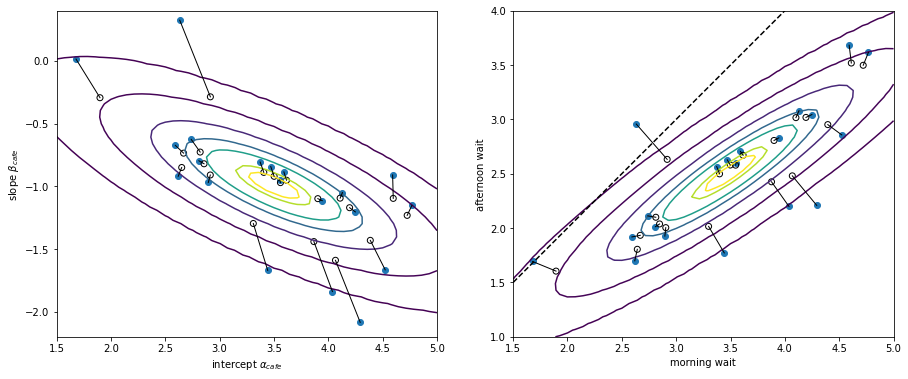

In [182]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

# plot intercepts vs slopes
plt.sca(axes[0])
# compute unpooled estimates from data
means = df.groupby(["cafe", "afternoon"])["wait"].mean()
a1 = means[:,0].values
b1 = means[:,1].values - a1
# extract posterior means of partially pooled estimates
s = m14_1.get_samples()
a2 = s["cafe"][:,:,0].mean(dim=0).numpy()
b2 = s["cafe"][:,:,1].mean(dim=0).numpy()
# plot and connect with lines
for i in range(len(a1)):
    plt.scatter(a1[i], b1[i], color="C0")
    plt.scatter(a2[i], b2[i], facecolor="none", edgecolor="black")
    plt.plot([a1[i], a2[i]], [b1[i], b2[i]], color="black", linewidth=1)
# plot pooled density contours for the pooled population
S = np.cov([a2, b2])
mu = np.mean([a2, b2], axis=1)[:,None,None]
XY = np.stack(np.meshgrid(np.linspace(1.5, 5), np.linspace(-2.2, 0.4)))
Z = np.exp(-np.einsum("abc,ad,dbc->bc", XY-mu, np.linalg.inv(S), XY-mu))
plt.contour(XY[0], XY[1], Z, levels=[1e-4, 1e-2, 1e-1, 0.3, 0.5, 0.8, 0.9])
plt.xlabel(r"intercept $\alpha_{cafe}$")
plt.ylabel(r"slope $\beta_{cafe}$")

# plot morning vs afternoon wait times
plt.sca(axes[1])
# compute unpooled estimates from data
means = df.groupby(["cafe", "afternoon"])["wait"].mean()
a1 = means[:,0].values
b1 = means[:,1].values
# extract posterior means of partially pooled estimates
W = Predictive(model_m14_1, m14_1.get_samples(), return_sites=("W",))(data)["W"].mean(dim=0)
_df = df.copy()
_df["post_wait"] = W
means = _df.groupby(["cafe", "afternoon"])["post_wait"].mean()
a2 = means[:,0].values
b2 = means[:,1].values
# plot and connect with lines
for i in range(len(a1)):
    plt.scatter(a1[i], b1[i], color="C0")
    plt.scatter(a2[i], b2[i], facecolor="none", edgecolor="black")
    plt.plot([a1[i], a2[i]], [b1[i], b2[i]], color="black", linewidth=1)
# plot pooled density contours for the pooled population
S = np.cov([a2, b2])
mu = np.mean([a2, b2], axis=1)[:,None,None]
XY = np.stack(np.meshgrid(np.linspace(1.5, 5), np.linspace(1, 4)))
Z = np.exp(-np.einsum("abc,ad,dbc->bc", XY-mu, np.linalg.inv(S), XY-mu))
plt.contour(XY[0], XY[1], Z, levels=[1e-4, 1e-2, 1e-1, 0.3, 0.5, 0.8, 0.9])
x, y = XY[0,0,:][[0, -1]], XY[1,:,0][[0, -1]]
x = np.linspace(max(x[0], y[0]), min(x[1], y[1]))
plt.plot(x, x, color="black", linestyle="--")
plt.xlabel("morning wait")
plt.ylabel("afternoon wait")

plt.show()

## Code 14.18 - 14.22
The previous section showed how to incorporate pooled correlations across two different types of variables (intercepts/slopes) within the same type of category (cafes). But is it possible to pool more than one type of variable, or across categories, while including correlations? Yes! We'll examine this in the context of the chimpanzee dataset.

In [3]:
chimp_df = pd.read_csv("data/chimpanzees.csv", sep=";")
chimp_df["treatment"] = chimp_df["prosoc_left"] + 2*chimp_df["condition"]

data = {
    "num_treatments": chimp_df["treatment"].nunique(),
    "num_blocks": chimp_df["block"].nunique(),
    "num_actors": chimp_df["actor"].nunique(),
    "L": tt(chimp_df["pulled_left"].values).double(),
    "treatment": tt(chimp_df["treatment"].values).long(),
    "actor": tt(chimp_df["actor"].values-1).long(),
    "block": tt(chimp_df["block"].values-1).long(),
}
chimp_df.sample(5)

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
318,5,NaN,0,6,62,1,0,0,1
153,3,NaN,0,2,19,1,1,1,1
263,4,3.0,1,2,24,1,1,1,3
253,4,3.0,1,1,4,0,1,0,2
86,2,NaN,0,3,29,1,1,1,1


Our model will consist of a sum of linear factors where we now take into account the interaction between actor/treatment and block/treatment:

$$\begin{align*}
L_i &\sim \text{Bernoulli}(p_i) \\
p_i &= \text{sigmoid}\left( \gamma_\text{TID[i]} + \alpha_\text{ACTOR[i],TID[i]} + \beta_\text{BLOCK[i],TID[i]} \right)
\end{align*}$$
This model contains an average intercept for each treatment $\gamma_\text{TID[i]}$, an effect for each actor in each treatment $\alpha_\text{ACTOR[i],TID[i]}$, and an effect for each block in each treatment $\beta_\text{BLOCK[i],TID[i]}$. This yields a total of $4+7\times 4 + 6\times 4=56$ parameters.

The next part of the model are the adaptive priors. Since there are two cluster types, there are two multivariate Gaussian priors, which are 4-dimensional, because there are 4 treatments.

$$\begin{align*}
\alpha_{j} &\sim \text{Normal}(0, \boldsymbol{S}_\text{ACTOR}) \\
\beta_{j} &\sim \text{Normal}(0, \boldsymbol{S}_\text{BLOCK}) 
\end{align*}$$

In [4]:
def model_m14_2(data, training=False):
    nT, nB, nA = [data[k] for k in ("num_treatments", "num_blocks", "num_actors")]
    σa = pyro.sample("σa", Exponential(1.))
    σb = pyro.sample("σb",Exponential(1.))
    Ra = pyro.sample("Ra", LKJCorrCholesky(nT, tt(2.)))
    Rb = pyro.sample("Rb", LKJCorrCholesky(nT, tt(2.)))
    Sa = torch.mm(torch.diag(torch.cat(nT*[σa.reshape(1)])), Ra)
    Sb = torch.mm(torch.diag(torch.cat(nT*[σa.reshape(1)])), Rb)
    α = pyro.sample("α", MultivariateNormal(torch.zeros([nT]), scale_tril=Sa).expand([nA]))
    β = pyro.sample("β", MultivariateNormal(torch.zeros([nT]), scale_tril=Sb).expand([nB]))
    γ = pyro.sample("γ", Normal(0., 1.).expand([nT]))
    T, A, B = [data[k] for k in ("treatment", "actor", "block")]
    p = torch.sigmoid(γ[T] + α[A,T] + β[B,T])
    if training:
        pyro.sample("L", Bernoulli(p), obs=data["L"])
    else:
        return pyro.sample("L", Bernoulli(p))

In [6]:
m14_2 = train_nuts(model_m14_2, data, 500, 1000, jit_compile=False)

Warmup:   0%|          | 1/1500 [00:00,  5.21it/s, step size=7.96e-01, acc. prob=0.933]

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': False}


Sample: 100%|██████████| 1500/1500 [05:11,  4.81it/s, step size=1.68e-01, acc. prob=0.917]


In [7]:
x = m14_2.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        σa      1.02      0.17      1.00      0.77      1.29    380.69      1.00
        σb      0.99      1.03      0.65      0.00      2.25   1138.79      1.00
   Ra[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
   Ra[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[0,2]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[0,3]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[1,0]      0.39      0.27      0.42     -0.06      0.81       nan      1.00
   Ra[1,1]      0.87      0.13      0.91      0.67      1.00       nan      1.00
   Ra[1,2]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[1,3]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[2,0]      0.59      0.20      0.61      0.33      0.90       nan      1.00
   Ra[2,1]      0.25      0

We can also use reparametrization of the normal distributions here to improve sampling efficiency. We can turn any normal sample from the centered parametrization

$$
x \sim \text{Normal}(\mu, \Sigma)
$$

into a non-centered parametrization of the form

$$
z \sim \text{Normal}(0, I) \\
x = \mu + Lz
$$

where $L$ is the Cholesky factor of the covariance matrix: $\Sigma = LL^T$

In [101]:
def model_m14_3(data, training=False):
    nT, nB, nA = [data[k] for k in ("num_treatments", "num_blocks", "num_actors")]
    σa = pyro.sample("σa", Exponential(1.))
    σb = pyro.sample("σb",Exponential(1.))
    Ra = pyro.sample("Ra", LKJCorrCholesky(nT, tt(2.)))
    Rb = pyro.sample("Rb", LKJCorrCholesky(nT, tt(2.)))
    Sa = torch.mm(torch.diag(torch.cat(nT*[σa.reshape(1)])), Ra)
    Sb = torch.mm(torch.diag(torch.cat(nT*[σa.reshape(1)])), Rb)
    zero = torch.zeros([nT])
    I = torch.eye(nT)
    α = torch.einsum("ij,kj->ki", Sa, pyro.sample("zα", MultivariateNormal(zero, I).expand([nA])))
    β = torch.einsum("ij,kj->ki", Sb, pyro.sample("zβ", MultivariateNormal(zero, I).expand([nB])))
    γ = pyro.sample("γ", Normal(0., 1.).expand([nT]))
    T, A, B = [data[k] for k in ("treatment", "actor", "block")]
    p = torch.sigmoid(γ[T] + α[A,T] + β[B,T])
    with pyro.plate("obs", dim=-1):
        if training:
            pyro.sample("L", Bernoulli(p), obs=data["L"])
        else:
            return pyro.sample("L", Bernoulli(p))

In [105]:
m14_3 = train_nuts(model_m14_3, data, 500, 1000, jit_compile=False)

Warmup:   0%|          | 0/1500 [00:00, ?it/s]

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': False}


Sample: 100%|██████████| 1500/1500 [03:48,  6.58it/s, step size=2.18e-01, acc. prob=0.882]


In [106]:
m14_3.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        σa      1.04      0.19      1.02      0.72      1.30    324.90      1.03
        σb      0.95      0.94      0.64      0.00      2.36   1054.07      1.00
   Ra[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
   Ra[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[0,2]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[0,3]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[1,0]      0.41      0.28      0.46     -0.03      0.84       nan      1.00
   Ra[1,1]      0.86      0.13      0.89      0.67      1.00       nan      1.00
   Ra[1,2]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[1,3]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[2,0]      0.60      0.20      0.63      0.29      0.92       nan      1.00
   Ra[2,1]      0.24      0

If we compare the centered and non-centered models, the improvement doesn't seem as great as the textbook makes it seem. The time to complete sampling is slightly lower for the non-centered model, but it is only a bit more efficient when looking at the effective number of samples:

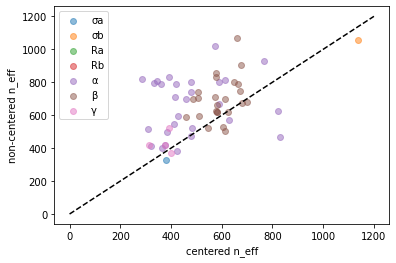

In [107]:
d1 = m14_2.diagnostics()
d2 = m14_3.diagnostics()
ignore = ("divergences", "acceptance rate")
for k1, k2 in zip(d1, d2):
    if k1 in ignore or k2 in ignore:
        continue
    plt.scatter(d1[k1]["n_eff"].reshape(-1), d2[k2]["n_eff"].reshape(-1), alpha=0.5, label=k1)
x = np.linspace(0, 1200)
plt.plot(x, x, color="black", linestyle="--")
plt.legend()
plt.xlabel("centered n_eff")
plt.ylabel("non-centered n_eff")
plt.show()

We can also compare the WAIC of the two models. We can see that even though there are >70 parameters (56 original parameters plus the free parameters in the correlation matrices) the number of effective parameters is closer to 30.

In [213]:
def get_log_prob(mcmc, data, site_names):
    samples = mcmc.get_samples()
    model = mcmc.kernel.model
    # get number of samples
    N = [v.shape[0] for v in samples.values()]
    assert [n == N[0] for n in N]
    N = N[0]
    if isinstance(site_names, str):
        site_names = [site_names]
    # iterate over samples
    log_prob = torch.zeros(N, len(data[site_names[0]]))
    for i in range(N):
        # condition on samples and get trace
        s = {k: v[i] for k, v in samples.items()}
        for nm in site_names:
            s[nm] = data[nm]
        tr = poutine.trace(poutine.condition(model, data=s)).get_trace(data)
        # get pointwise log probability
        for nm in site_names:
            node = tr.nodes[nm]
            log_prob[i] += node["fn"].log_prob(node["value"])
    return log_prob

In [216]:
az_data = dict()
for nm, model in (("m14.2", m14_2), ("m14.3", m14_3)):
    az_data[nm] = az.from_pyro(model, log_likelihood=False)
    ll = get_log_prob(model, data, "L")[None,...].numpy()
    ll = az.convert_to_dataset(ll, group="log_likelihood")
    az_data[nm].log_likelihood = ll
    az_data[nm]._groups.append("log_likelihood")

In [219]:
az.compare(az_data, ic="waic", scale="deviance")

/home/ecotner/.local/lib/python3.7/site-packages/arviz/stats/stats.py:1415: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m14.2,0,548.275,31.0614,0,0.532473,19.1515,0,True,deviance
m14.3,1,548.544,31.4683,0.269428,0.467527,19.3157,0.565806,True,deviance


Let's take one final look at the posterior predictions against the average for each actor/treatment combo.

In [265]:
# get actual proportions
pl = chimp_df.groupby(["actor", "treatment"])["pulled_left"].mean().reset_index()
pl["actor"] -= 1
block = 4
# get posterior predictive samples
_data = {
    "actor": tt(pl["actor"].values).long(),
    "treatment": tt(pl["treatment"].values).long(),
    "block": block*torch.ones(len(pl)).long()
}
pred = Predictive(model_m14_2, m14_2.get_samples(), return_sites=list("αβγ"))(data)
# calculate posterior means/CI's
T, A, B = [_data[k] for k in ("treatment", "actor", "block")]
p = torch.sigmoid(pred["γ"][:,T] + pred["α"][:,A,T] + pred["β"][:,B,T])
p_mu = p.mean(dim=0)
p_ci = hpdi(p, prob=0.89, dim=0).T

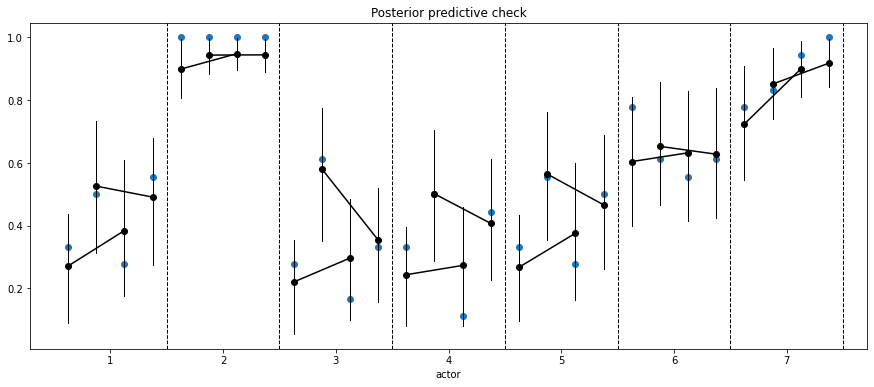

In [276]:
# make plot
plt.figure(figsize=(15, 6))
# plot data
plt.scatter(range(len(pl)), pl["pulled_left"], color="C0")
# plot posterior means
plt.scatter(range(len(pl)), p_mu, color="black")
# plot posterior CI's
for i in range(len(p_ci)):
    plt.plot(2*[i], p_ci[i], color="black", linewidth=1)
# connect the posterior means
for a in range(chimp_df["actor"].nunique()):
    for i in (0, 1):
        x = [4*a+i, 4*a+i+2]
        y = p_mu[[*x]]
        plt.plot(x, y, color="black")
    plt.axvline(4*(a+1)-0.5, color="black", linewidth=1, linestyle="--")
plt.xlabel("actor")
ticks = [4*(a+1)-2.5 for a in range(chimp_df["actor"].nunique())]
labels = [i+1 for i in range(chimp_df["actor"].nunique())]
plt.xticks(ticks, labels)
plt.title("Posterior predictive check")
plt.show()

### Code 14.23 - 14.28
We have seen that covariance and correlation are useful when specifying hierarchical models with adaptive priors. However, it can be useful for much more than that. Consider a study where we want to determine the effect of education ($E$) on wages ($W$). If we just blindly regress $W$ on $E$, we could end up with a biased result when $E$ and $W$ are both influenced by some unobserved confounding factor ($U$).

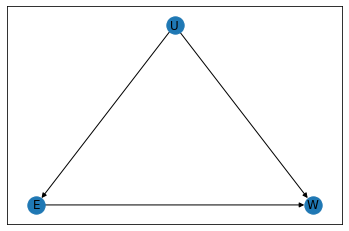

In [305]:
G = nx.DiGraph((("U","E"), ("U","W"), ("E","W")))
pos = {"E": (0, 0), "W": (1, 0), "U": (0.5, 0.5)}
nx.draw_networkx(G, pos); plt.show()

However, we can actually learn something about $U$ and tease out the actual effect of $E$ on $W$ by introducing an _instrumental variable_ $Q$, which only affects $E$, thereby turning it into a collider. (In the following example, $Q$ is a binary indicator that represents whether a subject was born during the first quarter of the year, the idea being that people born in Q1 will be older when they start school, and are eligible to drop out of school earlier.)

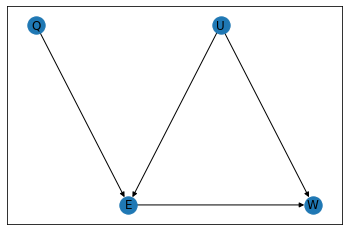

In [307]:
G = nx.DiGraph((("U","E"), ("U","W"), ("E","W"), ("Q", "E")))
pos = {"E": (0, 0), "W": (1, 0), "U": (0.5, 0.5), "Q": (-0.5, 0.5)}
nx.draw_networkx(G, pos); plt.show()

You can think of the instrumental variable (IV) as a light switch. A light $L$ being on depends on both the switch $S$ being turned on and the bulb $B$ being functional. If we turn on the switch but the light doesn't come on, then we can infer that the bulb must be broken. This is all possible because of the collider $S \rightarrow L \leftarrow B$.

We can create a generative model of this DAG and then re-learn its parameters to see the effect of the IV on our inference. Our ground-truth, generative model will be given by

$$\begin{align*}
W_i &\sim \text{Normal}(\mu_{W,i}, \sigma_W) \\
\mu_{W,i} &= \alpha_W + \beta_{EW} E_i + U_i \\
E_i &\sim \text{Normal}(\mu_{E,i}, \sigma_E) \\
\mu_{E,i} &= \alpha_E + \beta_{QE} Q_i + U_i \\
Q_i &\sim \text{Bernoulli}(0.25) \\
U_i &\sim \text{Normal}(0, 1)
\end{align*}$$

In [332]:
N = 500
U_sim = Normal(0., 1.).sample([N])
Q_sim = Bernoulli(0.25).sample([N])
E_sim = Normal(U_sim + Q_sim, 1.).sample()
W_sim = Normal(U_sim + 0*E_sim, 1.).sample()
data = dict(
    W = (W_sim - W_sim.mean())/W_sim.std(),
    E = (E_sim - E_sim.mean())/E_sim.std(),
    Q = (Q_sim - Q_sim.mean())/Q_sim.std(),
)

First, let's see what happens when we naiively regress $W$ on $E$

In [333]:
def model_m14_4(data, training=False):
    σ = pyro.sample("σ", Exponential(1.))
    αW = pyro.sample("αW", Normal(0., 0.2))
    βEW = pyro.sample("βEW", Normal(0., 0.5))
    μ = αW + βEW*data["E"]
    if training:
        pyro.sample("W", Normal(μ, σ), obs=data["W"])
    else:
        return pyro.sample("W", Normal(μ, σ))

In [334]:
m14_4 = train_nuts(model_m14_4, data, 500, 2000)

Warmup:   0%|          | 11/2500 [00:00, 106.32it/s, step size=1.81e-02, acc. prob=0.698]

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2500/2500 [00:10, 239.35it/s, step size=1.01e+00, acc. prob=0.869]


In [335]:
m14_4.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         σ      0.90      0.03      0.90      0.85      0.95   2899.58      1.00
        αW     -0.00      0.04     -0.00     -0.07      0.06   2683.24      1.00
       βEW      0.44      0.04      0.44      0.39      0.51   1910.83      1.00

Number of divergences: 0


We can see that this naiive model is very confident that $E$ has a strong positive effect on $W$. But we know better. Now, let's construct a smarter model that utilizes the IV $Q$.

$$\begin{align*}
\begin{pmatrix}W_i\\E_i\end{pmatrix} &\sim \text{Normal}\left(\begin{pmatrix}\mu_{W,i}\\\mu_{E_i}\end{pmatrix}, \boldsymbol{S}\right) \\
\mu_{W,i} &= \alpha_W + \beta_{EW} E_i \\
\mu_{E,i} &= \alpha_E + \beta_{QE} Q_i
\end{align*}$$

In [336]:
def model_m14_5(data, training=False):
    σ = pyro.sample("σ", Exponential(1.).expand([2]))
    R = pyro.sample("R", LKJCorrCholesky(2, tt(1.)))
    S = torch.diag(σ) @ R
    α = pyro.sample("α", Normal(0., 0.2).expand([2]))
    β = pyro.sample("β", Normal(0., 0.5).expand([2]))
    WE, EQ = torch.stack([data["W"], data["E"]], dim=1), torch.stack([data["E"], data["Q"]], dim=1)
    μ = α[None,:] + β[None,:]*EQ
    if training:
        pyro.sample("WE", MultivariateNormal(μ, scale_tril=S), obs=WE)
    else:
        return pyro.sample("WE", MultivariateNormal(μ, scale_tril=S))

In [337]:
m14_5 = train_nuts(model_m14_5, data, 500, 2000, jit_compile=False)

Warmup:   0%|          | 3/2500 [00:00, 29.11it/s, step size=6.73e-03, acc. prob=0.667]

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': False}


Sample: 100%|██████████| 2500/2500 [02:27, 16.95it/s, step size=2.42e-01, acc. prob=0.928]


In [338]:
m14_5.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      σ[0]      1.04      0.07      1.03      0.92      1.15    591.04      1.00
      σ[1]      0.95      0.03      0.95      0.90      0.99   1857.76      1.00
    R[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
    R[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
    R[1,0]      0.51      0.09      0.51      0.36      0.67       nan      1.00
    R[1,1]      0.85      0.06      0.86      0.76      0.95       nan      1.00
      α[0]     -0.00      0.05     -0.00     -0.08      0.07   1717.13      1.00
      α[1]     -0.00      0.04     -0.00     -0.07      0.07   1750.53      1.00
      β[0]     -0.06      0.13     -0.05     -0.28      0.15    647.77      1.00
      β[1]      0.33      0.04      0.33      0.26      0.40   1176.86      1.00

Number of divergences: 0


In [340]:
R = m14_5.get_samples()["R"]
torch.einsum("ijk,ilk->ijl", R, R).mean(dim=0)

tensor([[1.0000, 0.5102],
        [0.5102, 1.0000]])

We can see that the coefficient representing the effect of $E$ on $W$, $\beta_{EW}$ (`β[0]` in the code above) is consistent with zero, whereas the coefficient representing the effect of $Q$ on $E$, $\beta_{QE}$ (`β[1]` in the code) is decidedly positive. The correlation between $E$ and $W$ is also pretty high, as expected because of their relationship through the fork $E\leftarrow U \rightarrow W$.

Let's re-generate the data in a way such that the confounder $U$ is negatively correlated with $W$, and $E$ is very slightly positively correlated, so that the effect is that $U$ masks the influence of $E$.

In [341]:
N = 500
U_sim = Normal(0., 1.).sample([N])
Q_sim = Bernoulli(0.25).sample([N])
E_sim = Normal(U_sim + Q_sim, 1.).sample()
W_sim = Normal(-U_sim + 0.2*E_sim, 1.).sample()
data = dict(
    W = (W_sim - W_sim.mean())/W_sim.std(),
    E = (E_sim - E_sim.mean())/E_sim.std(),
    Q = (Q_sim - Q_sim.mean())/Q_sim.std(),
)

In [342]:
m14_5x = train_nuts(model_m14_5, data, 500, 2000, jit_compile=False)

Warmup:   0%|          | 3/2500 [00:00, 25.01it/s, step size=5.38e-02, acc. prob=0.667]

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': False}


Sample: 100%|██████████| 2500/2500 [02:27, 16.99it/s, step size=2.52e-01, acc. prob=0.927]


In [343]:
m14_5x.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      σ[0]      1.06      0.07      1.05      0.94      1.18    566.38      1.01
      σ[1]      0.95      0.03      0.95      0.90      1.00   2305.78      1.00
    R[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
    R[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
    R[1,0]     -0.43      0.11     -0.43     -0.60     -0.23       nan      1.00
    R[1,1]      0.90      0.05      0.90      0.82      0.99       nan      1.01
      α[0]     -0.00      0.05     -0.00     -0.08      0.08   1740.96      1.00
      α[1]     -0.00      0.04     -0.00     -0.07      0.06   1651.13      1.00
      β[0]      0.15      0.15      0.14     -0.10      0.39    568.97      1.01
      β[1]      0.31      0.04      0.31      0.24      0.37   1340.60      1.00

Number of divergences: 0


In [347]:
R = m14_5x.get_samples()["R"]
R = torch.einsum("ijk,ilk->ijl", R, R)
print("mean:")
print(R.mean(dim=0))
print("\nstd:")
print(R.std(dim=0))

mean:
tensor([[ 1.0000, -0.4278],
        [-0.4278,  1.0000]])

std:
tensor([[0.0000e+00, 1.1278e-01],
        [1.1278e-01, 4.7040e-08]])


$\beta_{EW}$ is still consistent with zero, but now has a slightly positive bias. We can also see from the correlation matrix that $E$ and $W$ are pretty strongly negatively correlated now. This is because $U$ positively influences $E$, and negatively influences $W$.

In the future, we can use a tool like [daggity](http://www.dagitty.net/) to help us figure out instrumental variables to use given a causal DAG.

The author also mentions that there is another useful technique for de-confounding known as the _front-door criterion_. Consider the the following DAG:

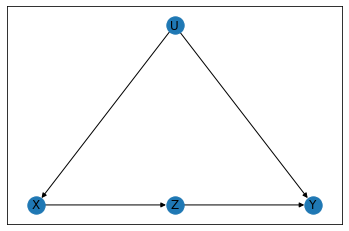

In [348]:
G = nx.DiGraph((("U", "X"), ("X", "Z"), ("Z", "Y"), ("U", "Y")))
pos = {"X": (0, 0), "Z": (1, 0), "Y": (2, 0), "U": (1, 1)}
nx.draw_networkx(G, pos); plt.show()

We can't directly estimate the effect of $X$ on $Y$ through regression because the unobserved $U$ acts as a confound. But through the front door path $X \rightarrow Z \rightarrow Y$, we can disentagle some of the effect of $U$. In the most extreme case, if $Z$ has zero influence on $Y$, then neither does $X$. In less extreme circumstances, we can combine the strength of $X \rightarrow Z$ and $Z \rightarrow Y$ to get a better estimate.

### Code 14.29 - 14.35

We will now explore multiple varying effects in the context of gift-giving among households in Nicaragua. We will build a "social relations model" (SRM) to determine the patterns of gift-giving among pairs of households.

In [3]:
kl_df = pd.read_csv("data/KosterLeckie.csv", sep=",")
kl_df.head()

,hidA,hidB,did,giftsAB,giftsBA,offset,drel1,drel2,drel3,drel4,dlndist,dass,d0125
0,1,2,1,0,4,0.000,0,0,1,0,-2.790,0.000,0
1,1,3,2,6,31,-0.003,0,1,0,0,-2.817,0.044,0
2,1,4,3,2,5,-0.019,0,1,0,0,-1.886,0.025,0
3,1,5,4,4,2,0.000,0,1,0,0,-1.892,0.011,0
4,1,6,5,8,2,-0.003,1,0,0,0,-3.499,0.022,0


In [4]:
print("# unique houses:", kl_df["hidA"].nunique())
print("# unique dyads:", kl_df["did"].nunique())

# unique houses: 24
# unique dyads: 300


Each house (which has a unique ID `hid`) part of (potentially) multiple _dyads_ (given by unique dyad ID `did`), or pairs. We will use a "social relations model" (SRM) to model the gift exchange. This model is essentially a Poisson regression on the number of gifts given by house $A$ to house $B$, where the linear model is a sum of some general intercept $\alpha$, a the giving tendency of some household $g_A$, the receiving tendency of some household $r_B$, and a dyad-specific rate that $A$ gives to $B$ $d_{AB}$:

$$
y_{A\rightarrow B} \sim \text{Poisson}(\lambda_{AB}) \\
\lambda_{AB} = \exp\left(\alpha + g_A + r_B + d_{AB}\right)
$$

The is also a corresponding model for the exchange in the other direction $y_{B\rightarrow A}$. So for each household $H$, we need two varying effects $g_H$ and $r_H$, and for each dyad $AB$ to varying effects $d_{AB}$ and $d_{BA}$. We also want to take into account any possible correlations within these groups, so we will use the following adaptive priors:

$$
\begin{pmatrix}g_i\\ r_i\end{pmatrix} \sim \text{Normal}\left(\begin{pmatrix}0\\0\end{pmatrix}, \begin{pmatrix}\sigma_g^2 & \sigma_g \sigma_r \rho_{gr} \\ \sigma_g \sigma_r \rho_{gr} & \sigma_r^2\end{pmatrix}\right) \\
\begin{pmatrix}d_{ij}\\ d_{ji}\end{pmatrix} \sim \text{Normal}\left(\begin{pmatrix}0\\0\end{pmatrix}, \begin{pmatrix}\sigma_d^2 & \sigma_d^2 \rho_{d} \\ \sigma_d^2 \rho_{d} & \sigma_r^2\end{pmatrix}\right)
$$

In [104]:
data = dict(
    N = len(kl_df),
    N_households = int(max(*[kl_df[k].max() for k in ("hidA", "hidB")])),
    did = tt(kl_df["did"].values-1).long(),
    hidA = tt(kl_df["hidA"].values-1).long(),
    hidB = tt(kl_df["hidB"].values-1).long(),
    giftsAB = tt(kl_df["giftsAB"].values).double(),
    giftsBA = tt(kl_df["giftsBA"].values).double(),
)

In [127]:
def model_m14_6(data, training=False):
    N, Nh = [data[k] for k in ("N", "N_households")]
    a = pyro.sample("α", Normal(0., 1.))
    # giving/receiving covariance matrix
    Rgr = pyro.sample("Rgr", LKJCorrCholesky(2, tt(1.5)))
    σgr = pyro.sample("σgr", Exponential(1.).expand([2]))
    Sgr = (torch.diag(σgr) @ Rgr)
    # dyad covariance matrix
    Rd = pyro.sample("Rd", LKJCorrCholesky(2, tt(1.5)))
    σd = pyro.sample("σd", Exponential(1.))
    Sd = (σd * Rd)
    # individual house giving/receiving variables
    zeros = torch.zeros(2).float()
    gr = pyro.sample("gr", MultivariateNormal(zeros, scale_tril=Sgr.float()).expand([Nh]))
    # dyad variables
    d = pyro.sample("d", MultivariateNormal(zeros, scale_tril=Sd.float()).expand([N]))
    # form the linear models
    A, B, did = [data[k] for k in ("hidA", "hidB", "did")]
    λAB = torch.exp(a + gr[A,0] + gr[B,1] + d[did,0])
    λBA = torch.exp(a + gr[B,0] + gr[A,1] + d[did,1])
    # observe outcomes
    if training:
        pyro.sample("giftsAB", Poisson(λAB), obs=data["giftsAB"])
        pyro.sample("giftsBA", Poisson(λBA), obs=data["giftsBA"])
    else:
        gAB = pyro.sample("giftsAB", Poisson(λAB))
        gBA = pyro.sample("giftsBA", Poisson(λBA))
        return torch.stack([gAB, gBA])

In [129]:
m14_6 = train_nuts(model_m14_6, data, 500, 1000, jit_compile=False)

Warmup:   0%|          | 1/1500 [00:00,  7.15it/s, step size=1.12e-01, acc. prob=1.000]

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': False}


Sample: 100%|██████████| 1500/1500 [11:20,  2.20it/s, step size=1.01e-01, acc. prob=0.850]


There are several hundred parameters in this model, so if I show all of their summary statistics, it might be a bit overwhelming. Instead, let's first examine just the covariance structure of the adaptive priors for the giving/receiving and dyad groups:

In [162]:
s = {k: v for k, v in m14_6.get_samples().items() if k in ("Rgr", "σgr")}
s["Rgr"] = torch.einsum("ijk,ilk->ijl", s["Rgr"], s["Rgr"])
df = []
for k, v in unnest_samples(s, 2).items():
    q = pyro.ops.stats.quantile(v, [0.05, 0.95])
    df.append({
        "param": k,
        "mean": v.mean().item(),
        "std": v.std().item(),
        "median": v.median().item(),
        "5.0%": q[0].item(),
        "95.0%": q[1].item(),
        "n_eff": pyro.ops.stats.effective_sample_size(v[None,:]).item(),
    })
pd.DataFrame(df).set_index("param")

,mean,std,median,5.0%,95.0%,n_eff
param,,,,,,
Rgr[0][0],1.000000,0.000000e+00,1.000000,1.000000,1.000000,NaN
Rgr[0][1],-0.542804,2.229791e-01,-0.577011,-0.849837,-0.128129,247.017776
Rgr[1][0],-0.542804,2.229791e-01,-0.577011,-0.849837,-0.128129,247.017776
Rgr[1][1],1.000000,3.508773e-08,1.000000,1.000000,1.000000,1005.769470
σgr[0],0.832847,1.372850e-01,0.818956,0.634873,1.085510,706.215210
σgr[1],0.416060,9.576137e-02,0.409397,0.273120,0.582019,326.100250


We can see that there is a pretty sizable negative correlation between ("generalized") giving and receiving. This means that across dyads, those who give more tend to receive less. The standard deviation parameters show that there is also a lot more variability in giving than there is in receiving. Let's plot the giving/receiving effects for each household.

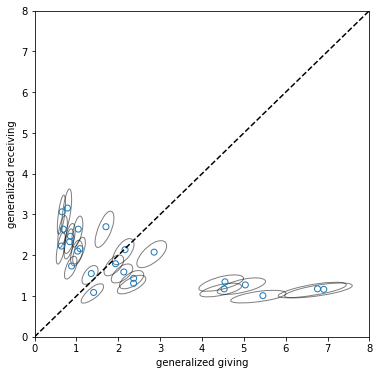

In [440]:
s = {k: v for k, v in m14_6.get_samples().items() if k in ("α", "gr")}
fig, ax = plt.subplots(figsize=(6, 6))
z = 2*np.sqrt(-2*np.log1p(-0.89)) # eigenvalue scaling factor to get 89% CI
for hid in range(data["N_households"]):
    g = s["α"] + s["gr"][:,hid,0]
    r = s["α"] + s["gr"][:,hid,1]
    plt.scatter(g.exp().mean(), r.exp().mean(), facecolor="none", edgecolor="C0")
    # make ellipse in unexponentiated space
    S = np.cov(torch.stack([g, r])) # covariance matrix
    w, v = np.linalg.eigh(S)
    angles = np.arctan2(*v) * (180/np.pi)
    idx = np.argmin(abs(angles))
    e = Ellipse((g.mean(), r.mean()), z*w[idx], z*w[1-idx], -angles[1-idx])
    # transform ellipse into exponentiated space
    path = e.get_transform().transform_path(e.get_path())
    path = Path(np.exp(path.vertices), path.codes)
    ax.add_patch(PathPatch(path, facecolor="none", edgecolor="black", alpha=0.5, zorder=-1))
#     sns.kdeplot(g.exp().numpy(), r.exp().numpy())
x = np.linspace(0, 8)
plt.plot(x, x, color="black", linestyle="--")
plt.xlim(left=0, right=8)
plt.ylim(bottom=0, top=8)
plt.xlabel("generalized giving")
plt.ylabel("generalized receiving")
plt.show()

We can see that there is indeed a negative correlation - houses that give the least recieve the most, and vice versa. Perhaps this is due to charity of the wealthy giving to those who need it the most (who can't afford to give themselves). Let's now take a look at how symmetric the dyad relationship is, controlling for the individual giving/receiving of each household.

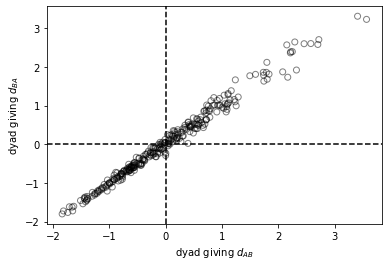

In [449]:
s = m14_6.get_samples()
dAB = s["d"][:,:,0].mean(dim=0)
dBA = s["d"][:,:,1].mean(dim=0)
plt.scatter(dAB, dBA, facecolor="none", edgecolor="black", alpha=0.5)
plt.axhline(0, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("dyad giving $d_{AB}$")
plt.ylabel("dyad giving $d_{BA}$")
plt.show()

The relationship is super symmetric, but with a lot more variation than the giving/receiving log-rates. It seems that these people try to match the level of gift giving they recieve (accounting for individual levels of wealth, generosity, etc).

### Code 14.36 - 14.45

Up until now, we have only looked at pooling groups of variables when the groups are discrete and unordered (groups of cafes, chimpanzees, tadpoles, households, etc). There is no sense in which cafe 1 comes before/after cafe 2, they are just labels. But what if we want to extend pooling to groups where the association is continuous? For example, we may have a dataset of people of various ages, and we want to pool across people with similar ages. If two people's ages are pretty close, they are probably more similar than people who are decades apart.

In order to do this, we'll have to make use of "Gaussian processes" (GP's), which basically promote the covariance matrix we've seen before to a covariance _function_, which allows calculating covariance between two continuously-indexed groups.

We will learn about GP's in the context of the Oceanic tool dataset we've seen before. Previously, we tried to take into account contact between societies with a binary variable. However, this doesn't take into account which societies interacted with each other (and possibly exchanged tools). We would expect that nearby societies probably had similar tool counts.

In [5]:
# get distance matrix between islands (units are thousands of kilometers)
dmatrix_df = pd.read_csv("data/islandsDistMatrix.csv").set_index("Unnamed: 0")
dmatrix_df.index.name = ""
dmatrix_df.head()

,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
,,,,,,,,,,
Malekula,0.000,0.475,0.631,4.363,1.234,2.036,3.178,2.794,1.860,5.678
Tikopia,0.475,0.000,0.315,4.173,1.236,2.007,2.877,2.670,1.965,5.283
Santa Cruz,0.631,0.315,0.000,3.859,1.550,1.708,2.588,2.356,2.279,5.401
Yap,4.363,4.173,3.859,0.000,5.391,2.462,1.555,1.616,6.136,7.178
Lau Fiji,1.234,1.236,1.550,5.391,0.000,3.219,4.027,3.906,0.763,4.884


In [6]:
# get normal dataset
island_df = pd.read_csv("data/islands.csv", sep=";")
island_df.head()

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0


In [7]:
data = {
    "N": len(island_df),
    "dmatrix": tt(dmatrix_df.values).double(),
    "dmatrix2": tt(dmatrix_df.values**2).double(),
    "id": tt(island_df.index.values).long(),
    "tools": tt(island_df["total_tools"].values).double(),
    "population": tt(island_df["population"].values).double(),
}

We will use the theoretically motivated model from before (power-law relationship between tools and population), but modify it with a multiplicative factor to account for distance between islands.

$$\begin{align*}
T_i &\sim \text{Poisson}(\lambda_i) \\
\lambda_i &= e^{k_i} \alpha P_i^\beta/\gamma \\
\vec{k} &\sim \text{Normal}(\vec{0}, \boldsymbol{K}) \\
K_{ij} &= \eta^2 \exp(-\rho^2 D_{ij}^2) + \delta_{ij}\sigma^2 \\
\alpha,\beta,\gamma &\sim \text{Exponential}(1) \\
\eta^2 &\sim \text{Exponential}(2) \\
\rho^2 &\sim \text{Exponential}(0.5) \\
\sigma &= 0.01
\end{align*}$$

In [594]:
def model_m14_7(data, training=False):
    a = pyro.sample("α", Exponential(1.))
    b = pyro.sample("β", Exponential(1.))
    g = pyro.sample("γ", Exponential(1.))
    η2 = pyro.sample("η2", Exponential(2.))
    ρ2 = pyro.sample("ρ2", Exponential(0.5))
    σ = tt(0.01)
    K = (η2 * torch.exp(-ρ2*data["dmatrix2"]) + torch.eye(data["N"]) * σ).float()
    zeros = torch.zeros(data["N"]).float()
    k = pyro.sample("k", MultivariateNormal(zeros, covariance_matrix=K))
    λ = (k.exp() * a * torch.pow(data["population"], b)/g).double()
    if training:
        pyro.sample("T", Poisson(λ), obs=data["tools"])
    else:
        return pyro.sample("T", Poisson(λ))

In [595]:
m14_7 = train_nuts(model_m14_7, data, 500, 2000, jit_compile=True)

Warmup:   0%|          | 0/2500 [00:00, ?it/s]/home/ecotner/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  import sys
Warmup:   0%|          | 1/2500 [00:00,  8.31it/s, step size=4.50e-01, acc. prob=1.000]

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2500/2500 [10:48,  3.85it/s, step size=3.77e-02, acc. prob=0.935]


In [596]:
m14_7.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         α      1.39      1.06      1.14      0.03      2.79    950.20      1.00
         β      0.28      0.08      0.28      0.16      0.43    536.63      1.00
         γ      0.61      0.55      0.44      0.01      1.36    704.97      1.00
        η2      0.18      0.18      0.13      0.01      0.41    498.58      1.00
        ρ2      1.42      1.67      0.82      0.01      3.60    894.55      1.00
      k[0]     -0.14      0.31     -0.14     -0.64      0.36    292.85      1.00
      k[1]      0.00      0.30      0.01     -0.48      0.50    294.84      1.00
      k[2]     -0.05      0.29     -0.04     -0.46      0.45    276.00      1.00
      k[3]      0.37      0.27      0.35     -0.03      0.79    321.38      1.00
      k[4]      0.09      0.26      0.08     -0.31      0.50    253.12      1.00
      k[5]     -0.36      0.28     -0.34     -0.81      0.08    234.14      1.00
      k[6]      0.16      0

Even though we sampled 2000 times, the number of effective samples is pretty low... Let's try a non-centered parametrization for the $k_i$:

In [8]:
def model_m14_7x(data, training=False):
    a = pyro.sample("α", Exponential(1.))
    b = pyro.sample("β", Exponential(1.))
    g = pyro.sample("γ", Exponential(1.))
    η2 = pyro.sample("η2", Exponential(2.))
    ρ2 = pyro.sample("ρ2", Exponential(0.5))
    σ = tt(0.01)
    K = (η2 * torch.exp(-ρ2*data["dmatrix2"]) + torch.eye(data["N"]) * σ).double()
    zeros = torch.zeros(data["N"]).float()
#     k = pyro.sample("k", MultivariateNormal(zeros, covariance_matrix=K))
    k = pyro.sample("k", MultivariateNormal(zeros, torch.eye(data["N"])))
    k = torch.cholesky(K) @ k.double()
    λ = (k.exp() * a * torch.pow(data["population"], b)/g).double()
    if training:
        pyro.sample("T", Poisson(λ), obs=data["tools"])
    else:
        return pyro.sample("T", Poisson(λ))

In [9]:
m14_7x = train_nuts(model_m14_7x, data, 500, 2000, jit_compile=True)

Warmup:   0%|          | 0/2500 [00:00, ?it/s]

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


/home/ecotner/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  import sys
Sample: 100%|██████████| 2500/2500 [10:36,  3.93it/s, step size=3.40e-02, acc. prob=0.942]


In [10]:
m14_7x.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         α      1.40      1.06      1.15      0.10      2.80   1853.07      1.00
         β      0.28      0.08      0.28      0.15      0.42    814.01      1.00
         γ      0.61      0.57      0.43      0.02      1.34   1311.84      1.00
        η2      0.20      0.21      0.13      0.01      0.42    834.48      1.00
        ρ2      1.34      1.74      0.67      0.01      3.53   1156.74      1.00
      k[0]     -0.45      0.74     -0.43     -1.60      0.86    950.94      1.00
      k[1]      0.40      0.74      0.41     -0.87      1.60   1188.90      1.00
      k[2]     -0.24      0.77     -0.22     -1.53      0.97   1911.56      1.00
      k[3]      0.96      0.65      0.94     -0.13      1.97   1111.17      1.00
      k[4]      0.37      0.66      0.34     -0.72      1.44   1305.15      1.00
      k[5]     -1.09      0.67     -1.07     -2.03      0.11   1570.92      1.00
      k[6]      0.33      0

Wow, that is a drastic improvement! The power of reparametrization is not to be understated! The results appear similar, except for the $k_i$'s, but that is because the samples recorded by the second model have not been adjusted by the correlation matrix. We can see what they'd look like after the transformation:

In [11]:
s = m14_7x.get_samples()
K = (
    s["η2"][:,None,None]
    * torch.exp(-s["ρ2"][:,None,None]*data["dmatrix2"][None,...])
    + torch.eye(data["N"])[None,...] * 0.01
)
k = torch.einsum("ijk,ik->ij", torch.cholesky(K).float(), s["k"])
df = []
for i in range(k.shape[1]):
    q = pyro.ops.stats.quantile(k[:,i], [0.05, 0.95])
    df.append({
        "": f"k[{i}]",
        "mean": k[:,i].mean().item(),
        "std": k[:,i].std().item(),
        "median": k[:,i].median().item(),
        "5.0%": q[0].item(),
        "95.0%": q[1].item(),
    })
pd.DataFrame(df).set_index("")

,mean,std,median,5.0%,95.0%
,,,,,
k[0],-0.169936,0.304936,-0.154794,-0.678256,0.315336
k[1],-0.027912,0.295744,-0.021205,-0.509921,0.439380
k[2],-0.080215,0.294264,-0.064190,-0.580881,0.383585
k[3],0.342883,0.263344,0.343994,-0.065955,0.768700
k[4],0.070763,0.254227,0.072881,-0.324530,0.473699
k[5],-0.389181,0.277629,-0.368863,-0.872324,0.021211
k[6],0.128450,0.252762,0.124566,-0.265776,0.531689
k[7],-0.222088,0.263705,-0.214507,-0.655488,0.168327
k[8],0.248329,0.249558,0.246527,-0.137739,0.658860


There are differences, but not anything major. I think we can be a bit more confident that the non-centered model is correct (and if anything, more correct than the centered one).

Now we want to understand the results. Let us plot the function defined by the parameters of the covariance matrix. How does the covariance fall off as a function of distance?

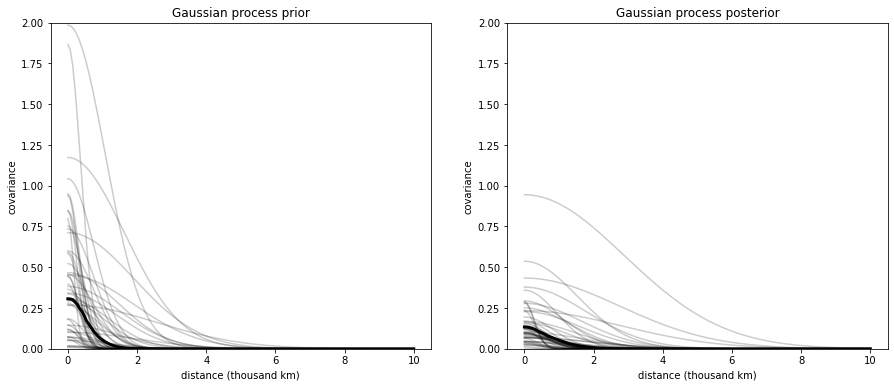

In [12]:
d = torch.linspace(0, 10, 150)
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
# plot prior
plt.sca(axes[0])
s = Predictive(model_m14_7x, {}, num_samples=1000)(data)
K = (
    s["η2"][:,None]
    * torch.exp(-s["ρ2"][:,None]*(d[None,:]**2))
)
idx = np.random.choice(1000, size=50)
for i in idx:
    plt.plot(d, K[i], color="black", alpha=0.2)
plt.plot(d, np.median(K, axis=0), color="black", linewidth=3)
plt.xlabel("distance (thousand km)")
plt.ylabel("covariance")
plt.ylim(bottom=0, top=2)
# plt.yscale("log")
plt.title("Gaussian process prior")
# plot posterior
plt.sca(axes[1])
s = m14_7x.get_samples()
K = (
    s["η2"][:,None]
    * torch.exp(-s["ρ2"][:,None]*(d[None,:]**2))
)
idx = np.random.choice(2000, size=50)
for i in idx:
    plt.plot(d, K[i], color="black", alpha=0.2)
plt.plot(d, np.median(K, axis=0), color="black", linewidth=3)
plt.xlabel("distance (thousand km)")
plt.ylabel("covariance")
plt.ylim(bottom=0, top=2)
# plt.yscale("log")
plt.title("Gaussian process posterior")
plt.show()

We can see that there is a good deal of uncertainty about the magnitude and suppression of the covariance (looks like long-tailed functions are not unlikely). Let's try and visualize this covariance in a geographic sense. I'll recreate the covariance matrix $\boldsymbol{K}$, then we can plot the connections on a crude map of the islands.

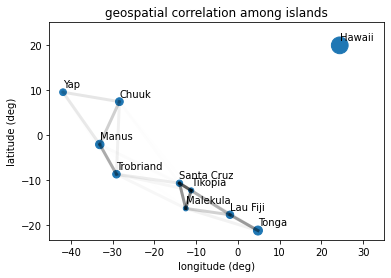

In [31]:
lon_lat = pd.read_csv("data/Kline2.csv", sep=";")[["lon2", "lat"]].values
s = m14_7x.get_samples()
K = np.median(
    s["η2"][:,None,None]
    * torch.exp(-s["ρ2"][:,None,None]*data["dmatrix2"][None,...])
    + torch.eye(data["N"])[None,...] * 0.01
, axis=0)
plt.scatter(*lon_lat.T, s=data["population"].pow(0.45))
for i in range(10):
    plt.annotate(island_df["culture"].iloc[i], lon_lat[i], (0, 5), textcoords="offset points")
for i in range(10):
    for j in range(i, 10):
        plt.plot(lon_lat[[i,j],0], lon_lat[[i,j],1], alpha=5*K[i,j].item(), color="black", linewidth=3)
plt.xlabel("longitude (deg)")
plt.ylabel("latitude (deg)")
plt.xlim(right=35)
plt.ylim(top=25)
plt.title("geospatial correlation among islands")
plt.show()

Let's do the same thing, but now on a plot of the log population vs. tool number.

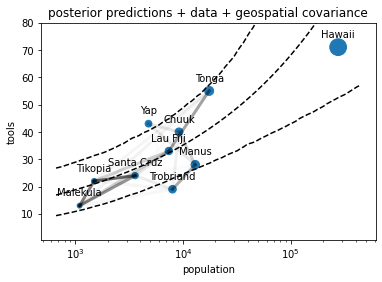

In [58]:
# plot posterior means/quantiles
P = torch.logspace(6.5, 13, base=np.e)
λ = s["α"][:,None]*(P[None,:]**s["β"][:,None])/s["γ"][:,None]
q = pyro.ops.stats.quantile(λ, [0.05, 0.95], dim=0)
mu = λ.mean(dim=0)
plt.plot(P, mu, color="black", linestyle="--")
plt.plot(P, q[0], color="black", linestyle="--")
plt.plot(P, q[1], color="black", linestyle="--")
# plot data
P, T = [data[k] for k in ("population", "tools")]
plt.scatter(P, T, s=data["population"].pow(0.45))
for i in range(10):
    plt.annotate(island_df["culture"].iloc[i], (P[i], T[i]), (0, 10), textcoords="offset points", horizontalalignment="center")
for i in range(10):
    for j in range(i, 10):
        plt.plot(P[[i,j]], T[[i,j]], alpha=5*K[i,j].item(), color="black", linewidth=3)
plt.xscale("log")
plt.ylim(top=80)
plt.xlabel("population")
plt.ylabel("tools")
plt.title("posterior predictions + data + geospatial covariance")
plt.show()

We can see that the geospatial similarity between Malekula, Tikopia, and Santa Cruz can account for the fact that they all have similar, below-average numbers of tools. And despite Fiji being relatively close to those three, the effect of Tonga pulls it up. There are perhaps other causal factors influencing the covariance between these islands other than just the propensity for tools to be exchanged; perhaps the abundance of materials used to make the tools is similar amongst islands that are close by. The model does not have a causal explanation for why proximity is important, just that it is.

### Code 14.46 - 14.??

Another way of utilizing GP's is to take into account proximity in _time_ rather than distance. In the context of evolutionary biology, species that have come from a common ancestral split are more similar to each other the closer they are to that split. Biologists can utilize a "pylogenetic regression" that takes this into account.

In [3]:
# load dataset of traits
phylo_df = pd.read_csv("data/Primates301.csv", sep=";")
phylo_df.head()

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.00,40.0,NaN,106.15,276.0,NaN,NaN
1,Allocebus_trichotis,Allocebus,trichotis,NaN,2,2,0.0,6.0,NaN,78.09,1.0,NaN,NaN,NaN,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.00,7.4,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.00,8.9,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.00,7.4,NaN,NaN,NaN,NaN,NaN


In [4]:
# load phylogenetic distance matrix
dmatrix_df = pd.read_csv("data/Primates301_distance_matrix.csv").set_index("Unnamed: 0")
dmatrix_df.index.name = ""
dmatrix_df.head()

,Allenopithecus_nigroviridis,Cercopithecus_albogularis,Cercopithecus_ascanius,Cercopithecus_campbelli,Cercopithecus_campbelli_lowei,Cercopithecus_cephus,Cercopithecus_cephus_cephus,Cercopithecus_cephus_ngottoensis,Cercopithecus_diana,Cercopithecus_erythrogaster,...,Galago_moholi,Galago_senegalensis,Galagoides_demidoff,Galagoides_zanzibaricus,Otolemur_crassicaudatus,Otolemur_garnettii,Tarsius_bancanus,Tarsius_dentatus,Tarsius_lariang,Tarsius_syrichta
,,,,,,,,,,,,,,,,,,,,,
Allenopithecus_nigroviridis,0.000000,23.789805,23.789805,23.789804,23.789804,23.789806,23.789806,23.789806,23.789804,23.789805,...,146.006037,146.006037,146.006036,146.006036,146.006037,146.006037,137.680065,137.680065,137.680065,137.680065
Cercopithecus_albogularis,23.789805,0.000000,12.858418,15.780435,15.780435,12.858419,12.858419,12.858419,15.780435,12.858418,...,146.006038,146.006038,146.006037,146.006037,146.006038,146.006038,137.680066,137.680066,137.680066,137.680066
Cercopithecus_ascanius,23.789805,12.858418,0.000000,15.780435,15.780435,4.037887,4.037887,4.037887,15.780435,5.463272,...,146.006038,146.006038,146.006037,146.006037,146.006038,146.006038,137.680066,137.680066,137.680066,137.680066
Cercopithecus_campbelli,23.789804,15.780435,15.780435,0.000000,0.548556,15.780436,15.780436,15.780436,11.974562,15.780435,...,146.006037,146.006037,146.006036,146.006036,146.006037,146.006037,137.680065,137.680065,137.680065,137.680065
Cercopithecus_campbelli_lowei,23.789804,15.780435,15.780435,0.548556,0.000000,15.780436,15.780436,15.780436,11.974562,15.780435,...,146.006037,146.006037,146.006036,146.006036,146.006037,146.006037,137.680065,137.680065,137.680065,137.680065


First, we will imagine trying to figure out whether "group size" (the typical size of a species' social group) influences brain size. Perhaps having a bigger brain helps to manage all the social intricacies required of group living. This implies the following causal time series:

In [86]:
G = nx.DiGraph()
G.add_nodes_from([
    (1, dict(label=r"$U_{t-1}$", pos=(0, 0), color="#cccccc")),
    (2, dict(label=r"$B_{t-1}$", pos=(0, 0.5), color="#cccccc")),
    (3, dict(label=r"$G_{t-1}$", pos=(0, 1), color="#cccccc")),
    (4, dict(label=r"$G_{t}$", pos=(1, 1), color="white")),
    (5, dict(label=r"$B_{t}$", pos=(1, 0.5), color="white")),
    (6, dict(label=r"$U_{t}$", pos=(1, 0), color="#cccccc")),
])
G.add_edges_from([(1,6), (1,5), (1,4), (2,5), (3,4)])
G.add_edge(3, 5, color="red")

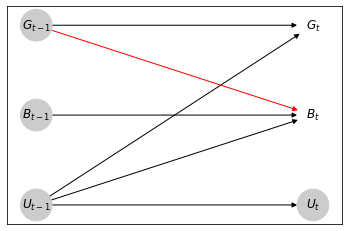

In [100]:
ncol = nx.get_node_attributes(G, "color").values()
ecol = [G.edges[e].get("color", "black") for e in G.edges]
pos = nx.get_node_attributes(G, "pos")
labels = nx.get_node_attributes(G, "label")
nx.draw_networkx(G, pos, labels=labels, node_color=ncol, edge_color=ecol, node_size=1000)
plt.show()

The grey nodes are unobserved factors (mostly attributes from the past/previous timestep), and the red edge is the relationship of interest - "does group size influence brain size?". We haven't observed any of the species attributes in the past, so how do we disentangle the effect of multiple influences on $B_t$?

Well, this graph only assumes a single species is at play. If we have multiple species in our dataset that have common ancestors, then we can pool across species to help estimate the unobserved factors in the past. And the closer those species are to the common ancestor, the more they will influence the pooling. This is the main thrust of the idea.

Let's re-draw our causal graph, taking the phylogenetic ancestry ($P$) into account

In [108]:
G = nx.DiGraph()
G.add_nodes_from([
    ("U", dict(pos=(0.5, 0), color="#cccccc")),
    ("P", dict(pos=(1, 0))),
    ("M", dict(pos=(0.5, 0.5))),
    ("G", dict(pos=(0, 1))),
    ("B", dict(pos=(1, 1)))
])
G.add_edges_from([("P", "U"), ("U", "G"), ("U", "M"), ("U", "B"), ("M", "G"), ("M", "B")])
G.add_edge("G", "B", color="red")

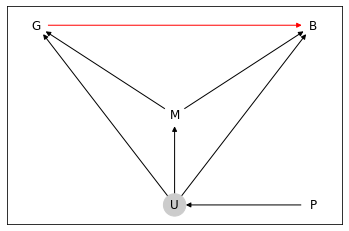

In [116]:
ncol = [G.nodes[n].get("color", "white") for n in G.nodes]
ecol = [G.edges[e].get("color", "black") for e in G.edges]
pos = nx.get_node_attributes(G, "pos")
nx.draw_networkx(G, pos, edge_color=ecol, node_color=ncol, node_size=500)
plt.show()

We know for a fact that one of the confounders of this relationship between $G$ and $B$ is the body mass $M$, which could potentially influence both. We can close off this backdoor by conditioning on $M$. There is also unfortunately a backdoor through $U$ which we cannot condition on. However, the phylogenetic ancestry factors $P$ can be used to help disentangle its influence, by taking into account the covariation of $B$ among many different species. This implies a model of the form

$$\begin{align*}
\vec{B} &\sim \text{Normal}(\vec{\mu}, \boldsymbol{S}) \\
\mu_i &= \alpha + \beta_G G_i + \beta_M M_i
\end{align*}$$
In an ordinary regression, the covariance matrix $\boldsymbol{S}$ is simply proportional to the identity matrix $\boldsymbol{S} = \sigma^2 \boldsymbol{I}$, but this doesn't take into account any of the phylogenetic distances. Let's pretend this is true for now and see what happens.

In [117]:
phylo_df.head()

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.00,40.0,NaN,106.15,276.0,NaN,NaN
1,Allocebus_trichotis,Allocebus,trichotis,NaN,2,2,0.0,6.0,NaN,78.09,1.0,NaN,NaN,NaN,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.00,7.4,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.00,8.9,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.00,7.4,NaN,NaN,NaN,NaN,NaN


In [158]:
def standardize(x):
    x = x.log()
    return (x - x.mean())/x.std()

df = phylo_df[["group_size", "body", "brain"]].copy()
df = df[~df.isna().any(axis=1)]

data = {
    "N": len(df),
    "group": standardize(tt(df["group_size"].values).double()),
    "mass": standardize(tt(df["body"].values).double()),
    "brain": standardize(tt(df["brain"].values).double()),
    "I": torch.eye(len(df)).double(),
}

In [160]:
def model_m14_8(data, training=False):
    a = pyro.sample("α", Normal(0., 1.))
    bG = pyro.sample("βG", Normal(0., 0.5))
    bM = pyro.sample("βM", Normal(0., 0.5))
    sigma2 = pyro.sample("σ2", Exponential(1.))
    S = sigma2 * data["I"]
    mu = a + bM * data["mass"] + bG * data["group"]
    if training:
        pyro.sample("B", MultivariateNormal(mu, S), obs=data["brain"])
    else:
        return pyro.sample("B", MultivariateNormal(mu, S))

In [161]:
m14_8 = train_nuts(model_m14_8, data, 500, 2000)

Warmup:   0%|          | 1/2500 [00:00,  9.31it/s, step size=4.50e-01, acc. prob=1.000]

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2500/2500 [00:41, 59.63it/s, step size=5.34e-01, acc. prob=0.911]


In [162]:
m14_8.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         α     -0.00      0.02     -0.00     -0.03      0.03   2106.99      1.00
        βG      0.12      0.02      0.12      0.09      0.16   1825.68      1.00
        βM      0.89      0.02      0.89      0.86      0.93   1774.53      1.00
        σ2      0.05      0.01      0.05      0.04      0.06   1720.05      1.00

Number of divergences: 0


Looks like a reliable positive association between group size and brain size then. But we know that there are confounding factors that we aren't taking into account... we need to use the phylogenetic distance to help disentangle them. The original way to take this into account is to treat evolutionary drift as a diffusion process, goverened by _Brownian motion_ (in physics, this is the model by which simple kinetic diffusion occurs in a gas). The mathematical basis of this is called a [_Wiener process_](https://en.wikipedia.org/wiki/Wiener_process). For a Weiner process, the covariance between two points separated in time is simply the time since the earlier of those two times $\text{cov}(W_s, W_t) = \min(s, t)$, and their correlation is $\text{corr}(W_s, W_t) = \sqrt{s/t}$ ($t\ge s$). However, the covariance matrix for $B$ that we're using in our model isn't the same thing as the Weiner process covariance, but is actually a monotonically decreasing _linear_ transformation:

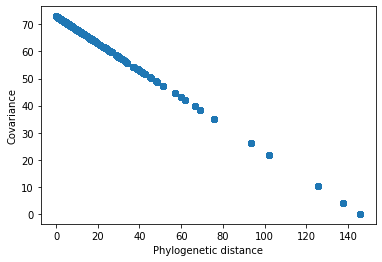

In [181]:
V = pd.read_csv("data/Primates301_vcov_matrix.csv").set_index("Unnamed: 0")
V.index.name = ""
plt.scatter(dmatrix_df.values.flatten(), V.values.flatten())
plt.xlabel("Phylogenetic distance")
plt.ylabel("Covariance")
plt.show()

We can confirm that this is indeed the transformation used:

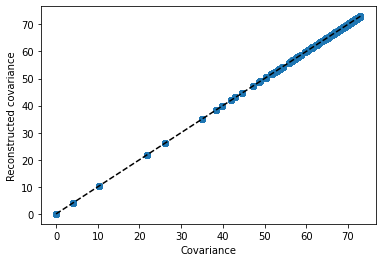

In [186]:
_V = dmatrix_df.values
_V = V.values.max() - (V.values.max()/_V.max()) * _V
plt.scatter(V.values.flatten(), _V.flatten())
x = np.linspace(0, V.values.max())
plt.plot(x, x, color="black", linestyle="--")
plt.xlabel("Covariance")
plt.ylabel("Reconstructed covariance")
plt.show()

In [204]:
df = phylo_df.set_index("name")[["group_size", "body", "brain"]].copy()
mask = ~df.isna().any(axis=1)
df = df[mask]
mask = mask[mask]
_V = V.loc[mask.index, mask.index].values

data = {
    "N": len(df),
    "group": standardize(tt(df["group_size"].values).double()),
    "mass": standardize(tt(df["body"].values).double()),
    "brain": standardize(tt(df["brain"].values).double()),
    "R": tt(_V/_V.max()).double(),
}

In [206]:
def model_m14_9(data, training=False):
    a = pyro.sample("α", Normal(0., 1.))
    bG = pyro.sample("βG", Normal(0., 0.5))
    bM = pyro.sample("βM", Normal(0., 0.5))
    sigma2 = pyro.sample("σ2", Exponential(1.))
    S = sigma2 * data["R"]
    mu = a + bM * data["mass"] + bG * data["group"]
    if training:
        pyro.sample("B", MultivariateNormal(mu, S), obs=data["brain"])
    else:
        return pyro.sample("B", MultivariateNormal(mu, S))

In [207]:
m14_9 = train_nuts(model_m14_9, data, 500, 2000)

Warmup:   0%|          | 5/2500 [00:00, 47.47it/s, step size=6.27e-02, acc. prob=0.599]

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2500/2500 [00:35, 69.63it/s, step size=8.00e-01, acc. prob=0.901]


In [208]:
m14_9.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         α     -0.19      0.17     -0.19     -0.49      0.06   2142.86      1.00
        βG     -0.01      0.02     -0.01     -0.05      0.02   1749.37      1.00
        βM      0.70      0.04      0.70      0.65      0.76   1615.16      1.00
        σ2      0.16      0.02      0.16      0.13      0.19   1975.01      1.00

Number of divergences: 0


The inclusion of this covariance matrix has now completely eliminated the relationship between group size and brain size! The interpretation of this result is that there is likely a lot of clustering of brain size in the family tree, and this introduces a spurious correlation with group size, which also clusters in the tree. Providing the correlation matrix allows the model to take this clustering into account.

The Weiner process is kind of restrictive, in that it completely specifies the correlation beforehand, and only allows tuning of the magnitude of the covariance (at least the way that we have parametrized it). The covariance falls off very slowly with distance, and in kind of an arbitrary way. It might be better to use a _Ornstein-Uhlenbeck process_ (in physics, this describes the kinetic drift of a particle under friction), which is damped Brownian motion that returns towards the mean. The OU process defines the covariance as the exponential attenuation of the linear distance:

$$
K_{ij} = \eta^2 \exp\left(-\rho^2 D_{ij}\right) + \delta_{ij} \sigma
$$

In [253]:
df = phylo_df.set_index("name")[["group_size", "body", "brain"]].copy()
mask = ~df.isna().any(axis=1)
df = df[mask]
mask = mask[mask]
D = dmatrix_df.loc[mask.index, mask.index].values

data = {
    "N": len(df),
    "group": standardize(tt(df["group_size"].values).double()),
    "mass": standardize(tt(df["body"].values).double()),
    "brain": standardize(tt(df["brain"].values).double()),
    "D": tt(D/D.max()).double(),
}

In [254]:
def model_m14_10(data, training=False):
    a = pyro.sample("α", Normal(0., 1.))
    bG = pyro.sample("βG", Normal(0., 0.5))
    bM = pyro.sample("βM", Normal(0., 0.5))
    eta2 = pyro.sample("η2", Exponential(1.))
    rho2 = pyro.sample("ρ2", Normal(3., 0.5)).abs()
    mu = a + bM * data["mass"] + bG * data["group"]
    K = eta2 * torch.exp(-rho2 * data["D"]) + 0.01*torch.eye(data["N"])
    if training:
        pyro.sample("B", MultivariateNormal(mu, K), obs=data["brain"])
    else:
        return pyro.sample("B", MultivariateNormal(mu, K))

In [255]:
m14_10 = train_nuts(model_m14_10, data, 500, 2000)

Warmup:   0%|          | 1/2500 [00:00,  8.43it/s, step size=5.35e-01, acc. prob=0.715]

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2500/2500 [00:56, 44.09it/s, step size=5.63e-01, acc. prob=0.910]


In [256]:
m14_10.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         α     -0.07      0.10     -0.07     -0.22      0.09   1555.52      1.00
        βG      0.05      0.02      0.05      0.01      0.09   2146.98      1.00
        βM      0.83      0.03      0.83      0.78      0.88   1886.96      1.00
        η2      0.04      0.01      0.04      0.03      0.05   1403.71      1.00
        ρ2      2.26      0.49      2.26      1.46      3.06   1579.76      1.00

Number of divergences: 1


Now the group size appears to be associated with brain size again (although the effect is very small). Why is this the case? Well the covariance implied by the OU process must be pretty different than that implied by the Weiner process (duh). My hypothesis is that since the vast majority of species in the tree are _not_ related to each other, the Weiner covariance needs to be suppressed greatly (hence the small value of $\sigma^2$) to match take this into account, but it also ends up suppressing the correlation between species that _are_ related. The OU kernel is much more flexible (has two free parameters instead of one), and also falls off with increasing distance much faster (just look at the plots above and you'll see the Weiner kernel falls off _very_ slowly). Looking below you'll see the behavior of the OU kernel:

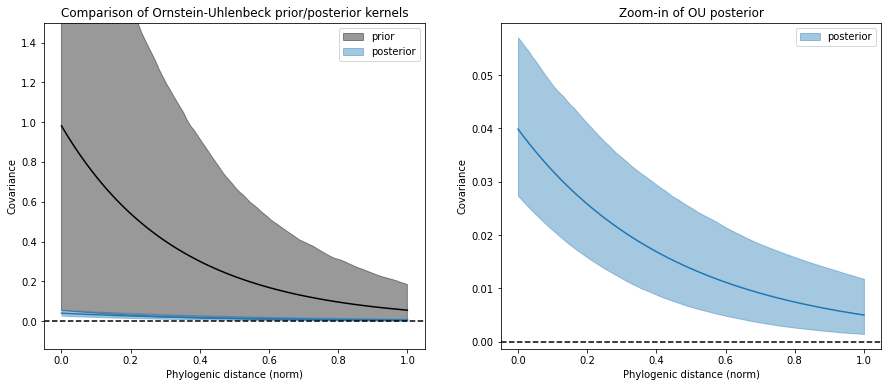

In [262]:
d = torch.linspace(0, 1, 100)
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
# plot prior function
plt.sca(axes[0])
s = Predictive(model_m14_10, {}, num_samples=1000)(data)
K = s["η2"][:,None].abs() * torch.exp(-s["ρ2"].abs()[:,None]*d[None,:])
mu_K = K.mean(dim=0)
q = pyro.ops.stats.quantile(K, [0.05, 0.95], dim=0)
plt.plot(d, mu_K, color="black")
plt.fill_between(d, *q, color="black", alpha=0.4, label="prior")
# plot posterior function
s = m14_10.get_samples()
K = s["η2"][:,None].abs() * torch.exp(-s["ρ2"].abs()[:,None]*d[None,:])
mu_K = K.mean(dim=0)
q = pyro.ops.stats.quantile(K, [0.05, 0.95], dim=0)
plt.plot(d, mu_K, color="C0")
plt.fill_between(d, *q, color="C0", alpha=0.4, label="posterior")
plt.axhline(0, color="black", linestyle="--")
plt.ylim(top=1.5)
plt.xlabel("Phylogenic distance (norm)")
plt.ylabel("Covariance")
plt.title("Comparison of Ornstein-Uhlenbeck prior/posterior kernels")
plt.legend()
# plot zoom-in of posterior
plt.sca(axes[1])
plt.plot(d, mu_K, color="C0")
plt.fill_between(d, *q, color="C0", alpha=0.4, label="posterior")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Phylogenic distance (norm)")
plt.ylabel("Covariance")
plt.title("Zoom-in of OU posterior")
plt.legend()
plt.show()

I'm curious why we chose a prior that is so different from the posterior... is this just to illustrate that we have so much data that the prior is irrelevant, or was it just a bad choice? Either way, the posterior seems to suggest that even at large phylogenic distances (i.e. $D/\max(D) \sim 1$), there is still a small, but nonzero amount of correlation. With the Weiner kernel, the covariance falls to zero at this point.